In [1]:
import sys
sys.path.append('../')
import numpy as np
from low_rank_rnns.modules import *
from low_rank_rnns import raposo, mante, clustering

In [2]:
size = 512
alpha = 0.2
noise_std = 5e-2

# Raposo task

In [3]:
x_train, y_train, mask_train, x_val, y_val, mask_val = raposo.generate_data(1000)

In [5]:
losses = []
accs = []
losses_trunc = {i: [] for i in range(1, 6)}
accs_trunc = {i: [] for i in range(1, 6)}
losses_res = {i: [] for i in range(1, 6)}
accs_res = {i: [] for i in range(1, 6)}
for i in range(10):
    net = FullRankRNN(2, size, 1, noise_std, alpha, train_wi=True, rho=0.2)
    J_init = net.wrec.detach().numpy().copy()
    train(net, x_train, y_train, mask_train, 20, lr=1e-3)
    loss, acc = raposo.test(net, x_val, y_val, mask_val)
    losses.append(loss)
    accs.append(acc)
    DJ = net.wrec.detach().numpy() - J_init
    u, s, v = np.linalg.svd(DJ)
    
    # Truncating
    for rank in range(1, 6):
        DJ_new = (u[:, :rank] * s[:rank]) @ v[:rank]
        m = u[:, :rank] * np.sqrt(s[:rank]) * np.sqrt(size)
        n = (v[:rank].T * np.sqrt(s[:rank])) * np.sqrt(size)
        net_trunc = LowRankRNN(2, size, 1, noise_std, alpha, rank=rank, wi_init=net.wi, wo_init=net.wo * size, 
                               m_init=torch.from_numpy(m), n_init=torch.from_numpy(n))
        loss, acc = raposo.test(net_trunc, x_val, y_val, mask_val)
        losses_trunc[rank].append(loss)
        accs_trunc[rank].append(acc)
        
        # Resampling
        net_res = clustering.to_support_net(net_trunc, np.zeros(size))
        losses_cur = []
        accs_cur = []
        for i in range(10):
            net_res.resample_basis()
            loss, acc = raposo.test(net_res, x_val, y_val, mask_val)
            losses_cur.append(loss)
            accs_cur.append(acc)
        losses_res[rank].append(losses_cur)
        accs_res[rank].append(accs_cur)

Training...
initial loss: 0.972
epoch 0:  loss=0.483  (took 0.70 s)
epoch 1:  loss=0.076  (took 0.71 s)
epoch 2:  loss=0.049  (took 0.69 s)
epoch 3:  loss=0.039  (took 0.69 s)
epoch 4:  loss=0.030  (took 0.68 s)
epoch 5:  loss=0.023  (took 0.69 s)
epoch 6:  loss=0.017  (took 0.70 s)
epoch 7:  loss=0.013  (took 0.69 s)
epoch 8:  loss=0.010  (took 0.69 s)
epoch 9:  loss=0.007  (took 0.69 s)
epoch 10:  loss=0.006  (took 0.70 s)
epoch 11:  loss=0.004  (took 0.71 s)
epoch 12:  loss=0.003  (took 0.71 s)
epoch 13:  loss=0.002  (took 0.71 s)
epoch 14:  loss=0.002  (took 0.71 s)
epoch 15:  loss=0.001  (took 0.70 s)
epoch 16:  loss=0.001  (took 0.74 s)
epoch 17:  loss=0.001  (took 0.77 s)
epoch 18:  loss=0.000  (took 0.79 s)
epoch 19:  loss=0.000  (took 0.83 s)
Training...
initial loss: 1.014
epoch 0:  loss=0.504  (took 0.71 s)
epoch 1:  loss=0.057  (took 0.73 s)
epoch 2:  loss=0.028  (took 0.75 s)
epoch 3:  loss=0.015  (took 0.78 s)
epoch 4:  loss=0.010  (took 0.76 s)
epoch 5:  loss=0.006  (too

In [15]:
accs_trunc.items()

dict_items([(1, [1.0, 1.0, 1.0, 0.9900000095367432, 1.0, 1.0, 1.0, 0.9900000095367432, 1.0, 0.9900000095367432]), (2, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), (3, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), (4, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), (5, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])])

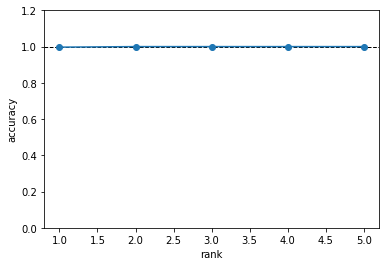

In [25]:
fig, ax = plt.subplots(1, 1)
keys = sorted(accs_trunc.keys())
ax.errorbar(keys, [np.mean(accs_trunc[r]) for r in keys], marker='o', yerr=[np.std(accs_trunc[r]) for r in keys])
ax.set_ylim(0, 1.2)
ax.set_xlabel('rank')
ax.set_ylabel('accuracy')
ax.axhline(1, c='k', zorder=-10, lw=1, ls='--')

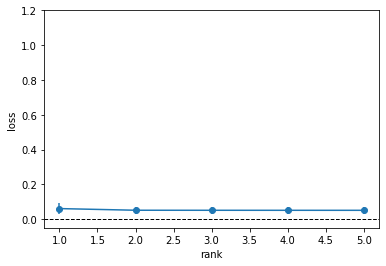

In [29]:
fig, ax = plt.subplots(1, 1)
keys = sorted(losses_trunc.keys())
ax.errorbar(keys, [np.mean(losses_trunc[r]) for r in keys], marker='o', yerr=[np.std(losses_trunc[r]) for r in keys])
ax.set_ylim(-0.05, 1.2)
ax.set_xlabel('rank')
ax.set_ylabel('loss')
ax.axhline(np.mean(losses), c='k', zorder=-10, lw=1, ls='--')

In [28]:
np.mean(losses)

0.0008079344348516315

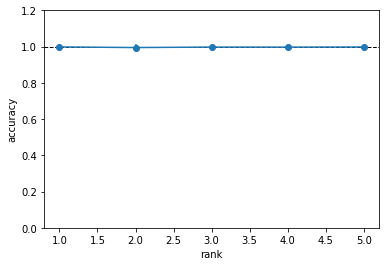

In [32]:
fig, ax = plt.subplots(1, 1)
keys = sorted(accs_res.keys())
ax.errorbar(keys, [np.mean(accs_res[r]) for r in keys], marker='o', yerr=[np.std(accs_res[r]) for r in keys])
ax.set_ylim(0, 1.2)
ax.set_xlabel('rank')
ax.set_ylabel('accuracy')
ax.axhline(1, c='k', zorder=-10, lw=1, ls='--')

In [31]:
np.mean(accs_res[1])

0.9982500010728836

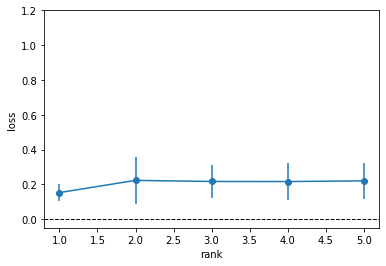

In [33]:
fig, ax = plt.subplots(1, 1)
keys = sorted(losses_res.keys())
ax.errorbar(keys, [np.mean(losses_res[r]) for r in keys], marker='o', yerr=[np.std(losses_res[r]) for r in keys])
ax.set_ylim(-0.05, 1.2)
ax.set_xlabel('rank')
ax.set_ylabel('loss')
ax.axhline(np.mean(losses), c='k', zorder=-10, lw=1, ls='--')

# Mante

In [35]:
x_train, y_train, mask_train, x_val, y_val, mask_val, _ = mante.generate_mante_data(1000, fraction_validation_trials=.2)

In [44]:
losses = []
accs = []
losses_trunc = {i: [] for i in range(1, 8)}
accs_trunc = {i: [] for i in range(1, 8)}
losses_res = {i: [] for i in range(1, 8)}
accs_res = {i: [] for i in range(1, 8)}
for i in range(10):
    net = FullRankRNN(4, size, 1, noise_std, alpha, train_wi=True, rho=0.2)
    J_init = net.wrec.detach().numpy().copy()
    train(net, x_train, y_train, mask_train, 20, lr=1e-3)
    loss, acc = raposo.test(net, x_val, y_val, mask_val)
    losses.append(loss)
    accs.append(acc)
    DJ = net.wrec.detach().numpy() - J_init
    u, s, v = np.linalg.svd(DJ + J_init)
    
    # Truncating
    for rank in range(1, 8):
        DJ_new = (u[:, :rank] * s[:rank]) @ v[:rank]
        m = u[:, :rank] * np.sqrt(s[:rank]) * np.sqrt(size)
        n = (v[:rank].T * np.sqrt(s[:rank])) * np.sqrt(size)
        net_trunc = LowRankRNN(4, size, 1, noise_std, alpha, rank=rank, wi_init=net.wi, wo_init=net.wo * size, 
                               m_init=torch.from_numpy(m), n_init=torch.from_numpy(n))
        loss, acc = raposo.test(net_trunc, x_val, y_val, mask_val)
        losses_trunc[rank].append(loss)
        accs_trunc[rank].append(acc)
        
        # Resampling
        net_res = clustering.to_support_net(net_trunc, np.zeros(size))
        losses_cur = []
        accs_cur = []
        for i in range(10):
            net_res.resample_basis()
            loss, acc = raposo.test(net_res, x_val, y_val, mask_val)
            losses_cur.append(loss)
            accs_cur.append(acc)
        losses_res[rank].append(losses_cur)
        accs_res[rank].append(accs_cur)

Training...
initial loss: 1.007
epoch 0:  loss=0.972  (took 0.73 s)
epoch 1:  loss=0.681  (took 0.74 s)
epoch 2:  loss=0.489  (took 0.72 s)
epoch 3:  loss=0.271  (took 0.72 s)
epoch 4:  loss=0.232  (took 0.74 s)
epoch 5:  loss=0.205  (took 0.72 s)
epoch 6:  loss=0.197  (took 0.73 s)
epoch 7:  loss=0.181  (took 0.74 s)
epoch 8:  loss=0.200  (took 0.75 s)
epoch 9:  loss=0.209  (took 0.78 s)
epoch 10:  loss=0.140  (took 0.78 s)
epoch 11:  loss=0.229  (took 0.73 s)
epoch 12:  loss=0.071  (took 0.75 s)
epoch 13:  loss=0.042  (took 0.81 s)
epoch 14:  loss=0.034  (took 0.88 s)
epoch 15:  loss=0.032  (took 0.84 s)
epoch 16:  loss=0.268  (took 0.92 s)
epoch 17:  loss=0.426  (took 0.86 s)
epoch 18:  loss=0.253  (took 0.88 s)
epoch 19:  loss=0.068  (took 0.80 s)
Training...
initial loss: 1.008
epoch 0:  loss=0.926  (took 0.80 s)
epoch 1:  loss=0.668  (took 0.79 s)
epoch 2:  loss=0.394  (took 0.80 s)
epoch 3:  loss=0.275  (took 0.79 s)
epoch 4:  loss=0.182  (took 0.80 s)
epoch 5:  loss=0.129  (too

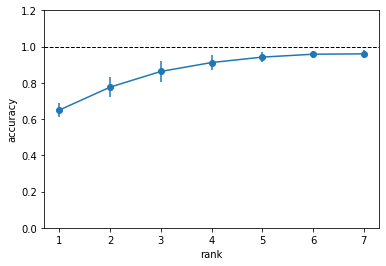

In [45]:
fig, ax = plt.subplots(1, 1)
keys = sorted(accs_trunc.keys())
ax.errorbar(keys, [np.mean(accs_trunc[r]) for r in keys], marker='o', yerr=[np.std(accs_trunc[r]) for r in keys])
ax.set_ylim(0, 1.2)
ax.set_xlabel('rank')
ax.set_ylabel('accuracy')
ax.axhline(1, c='k', zorder=-10, lw=1, ls='--')

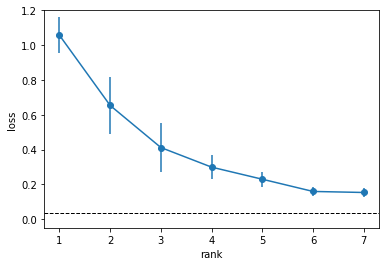

In [46]:
fig, ax = plt.subplots(1, 1)
keys = sorted(losses_trunc.keys())
ax.errorbar(keys, [np.mean(losses_trunc[r]) for r in keys], marker='o', yerr=[np.std(losses_trunc[r]) for r in keys])
ax.set_ylim(-0.05, 1.2)
ax.set_xlabel('rank')
ax.set_ylabel('loss')
ax.axhline(np.mean(losses), c='k', zorder=-10, lw=1, ls='--')

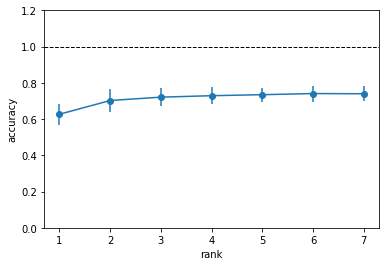

In [47]:
fig, ax = plt.subplots(1, 1)
keys = sorted(accs_res.keys())
ax.errorbar(keys, [np.mean(accs_res[r]) for r in keys], marker='o', yerr=[np.std(accs_res[r]) for r in keys])
ax.set_ylim(0, 1.2)
ax.set_xlabel('rank')
ax.set_ylabel('accuracy')
ax.axhline(1, c='k', zorder=-10, lw=1, ls='--')

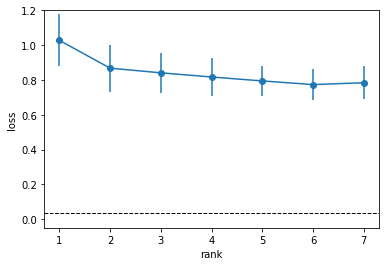

In [48]:
fig, ax = plt.subplots(1, 1)
keys = sorted(losses_res.keys())
ax.errorbar(keys, [np.mean(losses_res[r]) for r in keys], marker='o', yerr=[np.std(losses_res[r]) for r in keys])
ax.set_ylim(-0.05, 1.2)
ax.set_xlabel('rank')
ax.set_ylabel('loss')
ax.axhline(np.mean(losses), c='k', zorder=-10, lw=1, ls='--')